In [13]:
# 0. Imports and Global Config
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib


In [14]:
# Utility to get base directory, compatible with scripts and notebooks
def get_base_dir():
    # If __file__ is defined (script mode), use its directory, else current working dir
    base_dir = os.getcwd()
    try:
        if '__file__' in globals():
            base_dir = os.path.dirname(__file__)
    except NameError:
        pass
    return base_dir

In [15]:

# Load spaCy NER model once
def get_spacy_nlp():
    if spacy is None:
        raise ImportError(
            "spaCy is not installed. Install with: pip install spacy"
        )
    try:
        return spacy.load("en_core_web_sm")
    except OSError:
        raise OSError(
            "SpaCy model 'en_core_web_sm' not found. Install with: python -m spacy download en_core_web_sm"
        )


In [16]:
# 1. Data Collection & Heuristic Labeling

def load_raw_data(csv_filename: str = "raw_social_posts.csv") -> pd.DataFrame:
    """
    Load raw social media posts CSV with a 'text' column from data/ directory.
    """
    base_dir = get_base_dir()
    path = os.path.join(base_dir, "data", csv_filename)
    df = pd.read_csv(path)
    print(f"Loaded raw posts: {df.shape[0]} rows from {path}")
    return df


def compute_risk_scores(df: pd.DataFrame) -> pd.DataFrame:
    """
    Heuristic: count PII entities via spaCy NER and scale to 0-100 risk score.
    """
    nlp = get_spacy_nlp()
    pii_labels = {"PERSON","GPE","ORG","LOC","NORP","FAC","PRODUCT","EVENT","DATE","TIME","MONEY"}
    counts = []
    for doc in nlp.pipe(df['text'].astype(str), disable=["tagger","parser","lemmatizer"]):
        counts.append(sum(1 for ent in doc.ents if ent.label_ in pii_labels))
    df = df.copy()
    df['pii_count'] = counts
    max_count = df['pii_count'].max() if df['pii_count'].max() > 0 else 1
    df['risk_score'] = (df['pii_count'] / max_count) * 100
    df['risk_score'] = df['risk_score'].round(2)
    return df[['text', 'risk_score']]

In [17]:
# 2. Data Loading

def load_data(csv_filename: str = "social_posts_with_scores.csv") -> pd.DataFrame:
    """
    Load the annotated social media posts CSV from data/ directory.
    """
    base_dir = os.path.dirname(__file__)
    data_path = os.path.join(base_dir, "data", csv_filename)
    df = pd.read_csv(data_path)
    print("Loaded data with shape:", df.shape)
    return df

In [18]:
# 2. Data Loading

def load_data(csv_filename: str = "social_posts_with_scores.csv") -> pd.DataFrame:
    """
    Load annotated posts CSV from data/ directory.
    """
    base_dir = get_base_dir()
    path = os.path.join(base_dir, "data", csv_filename)
    df = pd.read_csv(path)
    print(f"Loaded labeled data: {df.shape[0]} rows from {path}")
    return df

In [19]:
# 3. Data Overview and EDA

def perform_eda(df: pd.DataFrame):
    print("\n--- Data Overview ---")
    print("Shape:", df.shape)
    print("Dtypes:\n", df.dtypes)
    print("Missing:\n", df.isnull().sum())
    print("Duplicates:", df.duplicated().sum())
    print("Stats:\n", df.describe(include='all'))

    # Univariate: risk_score
    plt.figure(); sns.boxplot(df['risk_score']); plt.title('Risk Score Boxplot'); plt.show()
    plt.figure(); sns.histplot(df['risk_score'], kde=True); plt.title('Risk Score Distribution'); plt.show()

    # Bivariate: text_length vs risk
    df['text_length'] = df['text'].str.len()
    plt.figure(); sns.scatterplot(x=df['text_length'], y=df['risk_score']); plt.title('Text Length vs Risk Score'); plt.show()
    # TODO: Document key insights here

In [20]:
# 4. Data Preprocessing

def preprocess_data(df: pd.DataFrame):
    X = df[['text']]
    y = df['risk_score']
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# 5. Model Building

def build_and_evaluate_models(X_train, X_test, y_train, y_test):
    pre = ColumnTransformer([('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2)), 'text')])
    models = {'RandomForest': RandomForestRegressor(random_state=42),
              'GradientBoosting': GradientBoostingRegressor(random_state=42)}
    results = {}
    for name, model in models.items():
        pipe = Pipeline([('pre', pre), ('model', model)])
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        results[name] = {
            'pipeline': pipe,
            'mse': mean_squared_error(y_test, preds),
            'r2': r2_score(y_test, preds)
        }
        print(f"{name} - MSE: {results[name]['mse']:.2f}, R2: {results[name]['r2']:.2f}")
    return results

In [22]:
# 6. Hyperparameter Tuning

def tune_model(pipeline: Pipeline, param_grid: dict, X_train, y_train):
    grid = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=3)
    grid.fit(X_train, y_train)
    print("Best Params:", grid.best_params_)
    return grid.best_estimator_

In [23]:

#. Model Comparison & Serialization

def compare_and_serialize(results: dict, X_test, y_test):
    best_name = min(results, key=lambda name: results[name]['mse'])
    best_pipe = results[best_name]['pipeline']
    print(f"Selected Best: {best_name}")
    joblib.dump(best_pipe, 'best_model.joblib')
    print("Saved best_model.joblib")
    loaded = joblib.load('best_model.joblib')
    print("Test MSE of Loaded:", mean_squared_error(y_test, loaded.predict(X_test)))


Loaded raw posts: 100 rows from C:\Users\suppe\OneDrive\github\ml-for-securitys\notebook\Social Media Privacy Score\data\raw_social_posts.csv
Labeled data saved to C:\Users\suppe\OneDrive\github\ml-for-securitys\notebook\Social Media Privacy Score\data\social_posts_with_scores.csv
Loaded labeled data: 100 rows from C:\Users\suppe\OneDrive\github\ml-for-securitys\notebook\Social Media Privacy Score\data\social_posts_with_scores.csv

--- Data Overview ---
Shape: (100, 2)
Dtypes:
 text           object
risk_score    float64
dtype: object
Missing:
 text          0
risk_score    0
dtype: int64
Duplicates: 26
Stats:
                                                      text  risk_score
count                                                 100  100.000000
unique                                                 74         NaN
top     RT @CMorhamed: He always gives me a cup of tea...         NaN
freq                                                   16         NaN
mean                           

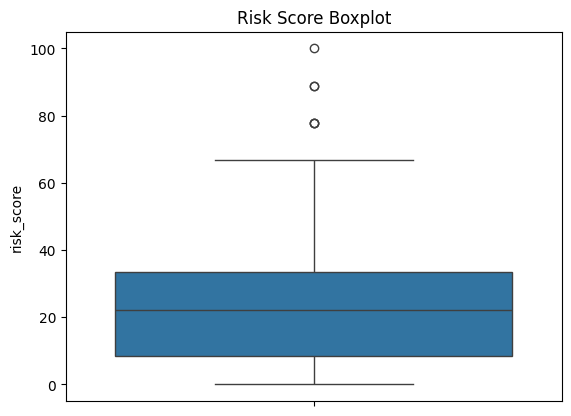

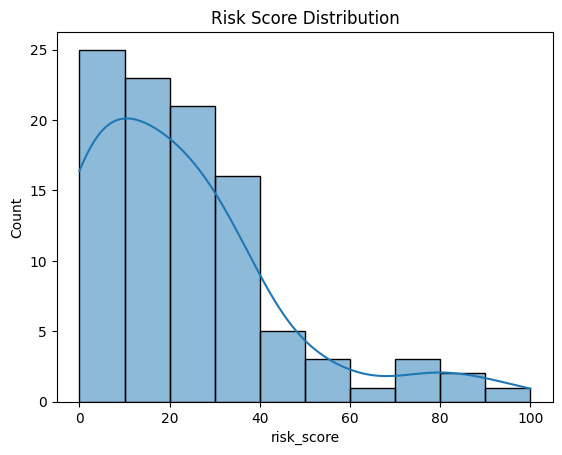

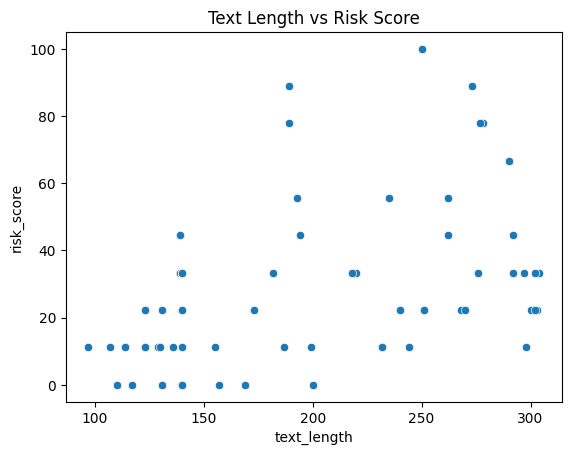

RandomForest - MSE: 306.75, R2: 0.24
GradientBoosting - MSE: 260.88, R2: 0.35
Best Params: {'model__max_depth': None, 'model__n_estimators': 50}
Selected Best: GradientBoosting
Saved best_model.joblib
Test MSE of Loaded: 260.88219825298984


In [24]:
# 8. Main Execution

if __name__ == '__main__':
    # Labeling
    raw_df = load_raw_data()
    labeled_df = compute_risk_scores(raw_df)
    # Save
    base_dir = get_base_dir()
    labeled_path = os.path.join(base_dir, 'data', 'social_posts_with_scores.csv')
    labeled_df.to_csv(labeled_path, index=False)
    print(f"Labeled data saved to {labeled_path}")

    # EDA & Preprocessing
    df = load_data()
    perform_eda(df)
    X_train, X_test, y_train, y_test = preprocess_data(df)

    # Build & Evaluate
    results = build_and_evaluate_models(X_train, X_test, y_train, y_test)

    # Tune RandomForest Example
    rf_pipe = results['RandomForest']['pipeline'] if 'RandomForest' in results else results['RandomForest']
    rf_grid = {'model__n_estimators': [50, 100], 'model__max_depth': [None, 10]}
    tuned_rf = tune_model(rf_pipe, rf_grid, X_train, y_train)
    results['RandomForest_Tuned'] = {
        'pipeline': tuned_rf,
        'mse': mean_squared_error(y_test, tuned_rf.predict(X_test)),
        'r2': r2_score(y_test, tuned_rf.predict(X_test))
    }

    # Compare & Serialize
    compare_and_serialize(results, X_test, y_test)
    # Next: Develop API (api/app.py) and UI (ui/app.py)